<a href="https://colab.research.google.com/github/mechanic3000/GB_algo_data/blob/master/Course_work_regr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from google.colab import files 
import io

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split


In [ ]:
train_csv = files.upload()
test_csv = files.upload()

Saving train.csv to train.csv


Saving test.csv to test.csv


In [ ]:
train_df = pd.read_csv(io.BytesIO(train_csv['train.csv']))
test_df = pd.read_csv(io.BytesIO(test_csv['test.csv']))

In [ ]:
train_df.head()

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points
0,0,40.0,0.0,1400.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,61
1,1,48.0,4.0,2850.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,76
2,2,39.0,0.0,1200.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,53
3,3,46.0,5.0,1400.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,54
4,4,43.0,1.0,1500.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,57


In [ ]:
train_df.shape, test_df.shape

((10000, 12), (10000, 11))

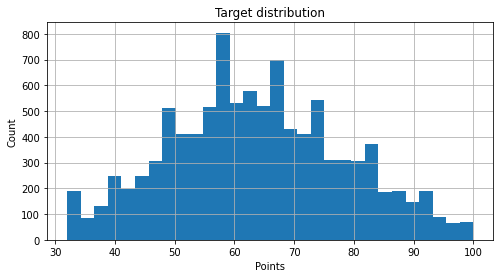

In [ ]:
plt.figure(figsize = (8, 4))

train_df['mean_exam_points'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Points')

plt.title('Target distribution')
plt.show()

In [ ]:
train_df.columns

Index(['Id', 'age', 'years_of_experience', 'lesson_price', 'qualification',
       'physics', 'chemistry', 'biology', 'english', 'geography', 'history',
       'mean_exam_points'],
      dtype='object')



```
Id - айди
age - возраст преподавателя
years_of_experience - стаж преподавателя
lesson_price - стоимость урока
qualification - квалификация преподавателя
physics - преподает ли физику
chemistry - преподает ли химию
biology - преподает ли биологию
english - преподает ли английский
geography - преподает ли географию
history - преподает ли историю
mean_exam_points - целевое значение, средний балл за экзамен учеников
```



In [ ]:
train_df.describe()

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4999.50000,45.878000,1.986800,1699.105000,1.719500,0.375000,0.132900,0.109600,0.053700,0.032100,0.019400,63.737300
std,2886.89568,8.043929,1.772213,524.886654,0.792264,0.484147,0.339484,0.312406,0.225436,0.176274,0.137933,14.705574
min,0.00000,23.000000,0.000000,200.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,32.000000
25%,2499.75000,40.000000,0.000000,1300.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,53.000000
50%,4999.50000,46.000000,2.000000,1500.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,63.000000
75%,7499.25000,51.000000,3.000000,2150.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,74.000000
max,9999.00000,68.000000,10.000000,3950.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,100.000000


In [ ]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узлеb

In [ ]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, target):
        self.data = data
        self.target = target
        self.prediction = self.predict()
        
    def predict(self):
        return np.mean(self.target)        

In [ ]:
def calc_mse(target):
    return np.mean((target - np.mean(target))**2)

In [ ]:
# Расчет прироста

def gain(left_labels, right_labels, root_mse):
  
    n_total = left_labels.shape[0] + right_labels.shape[0]
    
    return root_mse - (left_labels.shape[0] * calc_mse(left_labels) / n_total + 
                        right_labels.shape[0] * calc_mse(right_labels) / n_total)

In [ ]:
# Разбиение датасета в узле

def split(data, labels, column_index, t):
    
    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)
        
    true_data = data[left]
    false_data = data[right]
    
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels


In [ ]:
# Нахождение наилучшего разбиения (регрессия)

def find_best_split(data, target):
    
    #  обозначим минимальное количество объектов в узле
    min_samples_leaf = 3
    
    root_mse = calc_mse(target)

    best_gain = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique(data[:, index])

        for t in t_values:
            true_data, false_data, true_target, false_target = split(data, target, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_samples_leaf or len(false_data) < min_samples_leaf:
                continue
            
            current_gain = gain(true_target, false_target, root_mse)

            #  выбираем порог, на котором получается максимальный прирост качества
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index

In [ ]:
import time
# Построение дерева с помощью рекурсивной функции

def build_tree(data, target, max_deep=np.inf, curr_max_deep=0):

    gain, t, index = find_best_split(data, target)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if gain == 0:
        return Leaf(data, target)
    
    # Прекращаем рекурсию при достижении максимальной глубины дерева
    if max_deep <= curr_max_deep:
        return Leaf(data, target)

    true_data, false_data, true_target, false_target = split(data, target, index, t)

    curr_max_deep += 1 #следующая глубина дерева
    
    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_target, max_deep, curr_max_deep)

#     print(time.time(), true_branch)
    false_branch = build_tree(false_data, false_target, max_deep, curr_max_deep)
    
#     print(time.time(), false_branch)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [ ]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [ ]:
def predict(data, tree):

    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [ ]:
def get_bootstrap(data, labels, N):
    n_samples = data.shape[0] # размер совпадает с исходной выборкой
    bootstrap = []
    
    for i in range(N):
        
        sample_index = np.random.randint(0, n_samples, size=n_samples)
        b_data = data[sample_index]
        b_labels = labels[sample_index]
        
        bootstrap.append((b_data, b_labels))
        
    return bootstrap

In [ ]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = list(range(len_sample))

    len_subsample = int(np.round(np.sqrt(len_sample)))
    
    subsample = np.random.choice(sample_indexes, size=len_subsample, replace=False)

    return subsample

In [ ]:
def random_forest(data, labels, n_trees, max_depth):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels, max_depth))
        
    return forest

In [ ]:
# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
#     print(predictions)

    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
#     print(predictions_per_object)

    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

In [ ]:
features = [
'age', 
'years_of_experience', 
'lesson_price', 
'qualification',
'physics', 
'chemistry', 
'biology', 
'english', 
'geography', 
'history'
]

target = ['mean_exam_points']

In [ ]:
train_data, test_data, train_target, test_target = train_test_split(train_df[features].values, 
                                                                    train_df[target].values,
                                                                    test_size=0.3,
                                                                    random_state=1)

In [ ]:
train_data.shape, train_target.shape

((7000, 10), (7000, 1))

In [ ]:
%%time
n_trees = 45
my_forest = random_forest(train_data, train_target, n_trees, 4)

CPU times: user 18.7 s, sys: 190 ms, total: 18.9 s
Wall time: 19.8 s


In [ ]:
train_df_answers = tree_vote(my_forest, train_data)
test_df_answers = tree_vote(my_forest, test_data)

In [ ]:
from sklearn.metrics import r2_score

train_r2 = r2_score(train_target, train_df_answers)
test_r2 = r2_score(test_target, test_df_answers)

train_r2, test_r2

(0.6347262003031094, 0.6169028534376297)

In [ ]:
submit = files.upload()

Saving sample_submission.csv to sample_submission (2).csv


In [ ]:
submit = pd.read_csv(io.BytesIO(submit['sample_submission.csv']))

In [ ]:
test_predict = predict(test_df[features].values, my_tree)

In [ ]:
submit['mean_exam_points'] = test_predict
submit.head()

,Id,mean_exam_points
0,10000,54.271157
1,10001,62.743750
2,10002,52.068627
3,10003,90.232558
4,10004,86.282051


In [ ]:
submit.to_csv('rf_submit.csv', index=False)